In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from qkeras import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [2]:
train_df = pd.read_csv('train_2Dx.csv',nrows=1000000)
test_df = pd.read_csv('test_2Dx.csv',nrows=50000)

In [3]:
X_train = train_df.drop(columns=['x-midplane']).values
X_test = test_df.drop(columns=['x-midplane']).values

y_train = train_df['x-midplane'].values
y_test = test_df['x-midplane'].values

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [5]:
def custom_loss(y, p):
    
    maxval = 1e6
    minval = 1e-9
    pi = 3.14159265359
    
    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma = tf.clip_by_value(tf.gather(params=p, indices=[1], axis=1),minval,maxval)
        
    term = tf.clip_by_value(1.0/tf.math.sqrt(2*pi)/sigma*tf.math.exp(-1*(y-mu)*(y-mu)/(2*sigma*sigma)),minval,maxval)
    NLL = tf.clip_by_value(-1*tf.math.log(term),minval,maxval)
    
    return tf.keras.backend.sum(NLL,axis=1) 

In [6]:
#from qkeras import quantized bits
#from qkeras import QDense, QActivation
from qkeras import *

def CreateQModel(shape):
    x = x_in = Input(shape)
    x = QDense(64,
        kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    #x = BatchNormalization()(x)
    x = QActivation("quantized_relu(12,0)", name="relu-1")(x)
    x = QDense(2,
        kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateQModel(X_train.shape[1:])

model.compile(optimizer=Adam(),
              loss=custom_loss)

model.summary()

2022-11-01 18:29:02.216293: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 18:29:02.253235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 18:29:02.253558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 18:29:02.254619: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 168)]             0         
                                                                 
 dense1 (QDense)             (None, 64)                10816     
                                                                 
 relu-1 (QActivation)        (None, 64)                0         
                                                                 
 dense2 (QDense)             (None, 2)                 130       
                                                                 
Total params: 10,946
Trainable params: 10,946
Non-trainable params: 0
_________________________________________________________________


In [7]:
es = EarlyStopping(patience=5)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=80, 
                    batch_size=64,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/80
   93/12500 [..............................] - ETA: 20s - loss: 19.7730  

2022-11-01 18:29:06.533007: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


12500/12500 [==============================] - 28s 2ms/step - loss: 4.7644 - val_loss: 4.2380
Epoch 2/80
12500/12500 [==============================] - 26s 2ms/step - loss: 4.2205 - val_loss: 4.2072
Epoch 3/80
12500/12500 [==============================] - 26s 2ms/step - loss: 4.2009 - val_loss: 4.1978
Epoch 4/80
12500/12500 [==============================] - 27s 2ms/step - loss: 4.1913 - val_loss: 4.1835
Epoch 5/80
12500/12500 [==============================] - 26s 2ms/step - loss: 4.1826 - val_loss: 4.1758
Epoch 6/80
12500/12500 [==============================] - 25s 2ms/step - loss: 4.1795 - val_loss: 4.1718
Epoch 7/80
12500/12500 [==============================] - 25s 2ms/step - loss: 4.1756 - val_loss: 4.1690
Epoch 8/80
12500/12500 [==============================] - 25s 2ms/step - loss: 4.1744 - val_loss: 4.1667
Epoch 9/80
12500/12500 [==============================] - 25s 2ms/step - loss: 4.1682 - val_loss: 4.1621
Epoch 10/80
12500/12500 [==============================] - 26s 2ms

/tmp/ipykernel_51988/3321773974.py:10: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


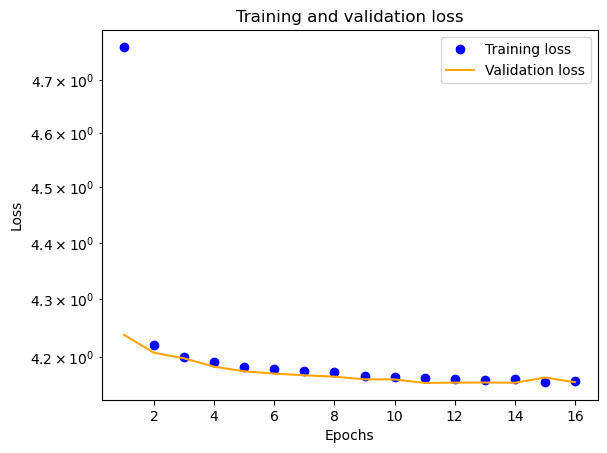

In [8]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('Log')
plt.legend()
plt.show()

In [9]:
model.save('models_2Dx/gauss6bit.keras')

In [10]:
p_test = model.predict(X_test)
np.savetxt("test_2DxGauss6bit.csv", p_test, delimiter=",")

In [11]:
residuals = y_test - p_test[:,0]
print(np.mean(residuals),np.std(residuals))

0.21048397298166016 20.726294824757527


In [12]:
uncertainty= p_test[:,1]
print(np.mean(uncertainty),np.std(uncertainty))

16.365627 6.519338


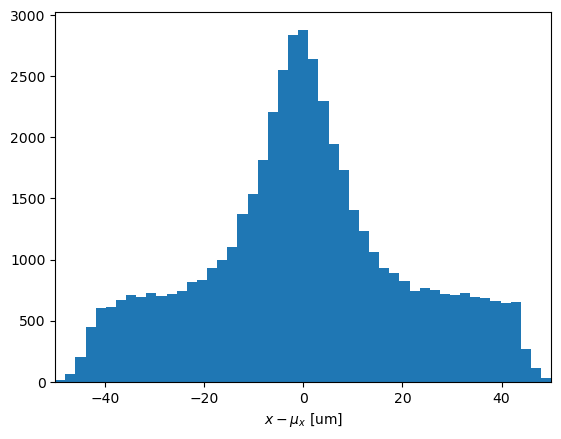

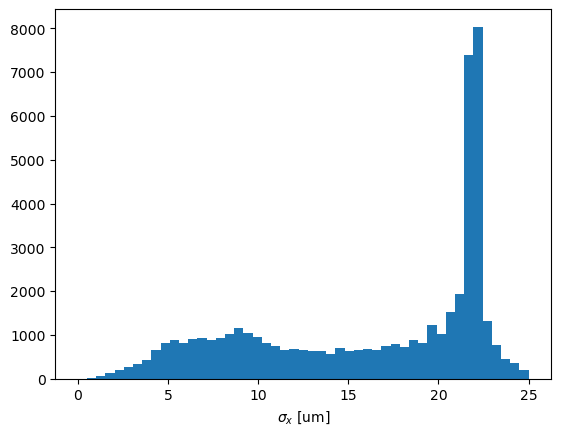

In [13]:
plt.hist(residuals,bins=np.linspace(-50,50,50))
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')
plt.xlim(-50,50)
plt.show()

plt.hist(uncertainty,bins=np.linspace(0,25,50));
#plt.yscale('Log')
plt.xlabel(r'$\sigma_x$ [um]')
plt.show()

In [14]:
pulls = residuals/p_test[:,1]
print(np.mean(pulls),np.std(pulls))

-0.029833847397494274 1.0864071460472062


Text(0.5, 0, 'pull')

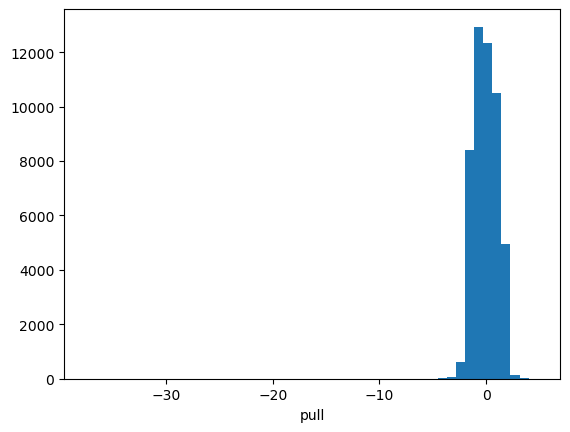

In [15]:
plt.hist(pulls,bins=50);
plt.xlabel('pull')

In [16]:
df_2d6 = pd.DataFrame(p_test,columns=['mu','sigma'])
df_2d6['xtrue'] = y_test
df_2d6.head()

,mu,sigma,xtrue
0,14.185333,17.222572,42.208390
1,24.666069,16.724571,17.997472
2,-19.941704,9.971329,-24.593676
3,28.782776,20.220276,51.074354
4,-31.810165,21.479370,-49.220710


In [17]:
df_2d5 = pd.read_csv('test_2DxGauss5bit.csv',header=None,names=['mu','sigma','xtrue'])
df_2d5.head()

,mu,sigma,xtrue
0,10.781677,18.393127,42.208390
1,24.504211,16.748108,17.997472
2,-20.406555,11.622314,-24.593676
3,28.654968,20.849670,51.074354
4,-31.022950,21.656189,-49.220710


In [18]:
df_2d = pd.read_csv('test_2DxGauss.csv',header=None,names=['mu','sigma','xtrue'])
df_2d.head()

,mu,sigma,xtrue
0,27.331068,5.774165,42.208390
1,18.190266,6.042384,17.997472
2,-26.164530,2.779754,-24.593676
3,52.052906,2.822005,51.074354
4,-46.877865,10.093211,-49.220710


Text(0.5, 0, '$x-\\mu_x$ [um]')

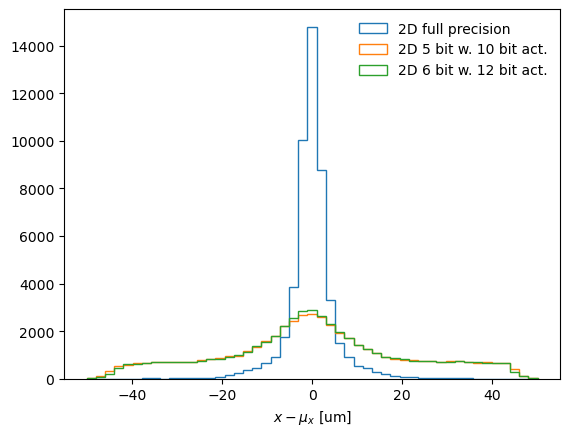

In [22]:
plt.hist(df_2d['xtrue'] - df_2d['mu'],histtype='step',bins=np.linspace(-50,50,50),label=r'2D full precision');
plt.hist(df_2d5['xtrue'] - df_2d5['mu'],histtype='step',bins=np.linspace(-50,50,50),label=r'2D 5 bit w. 10 bit act.');
plt.hist(df_2d6['xtrue'] - df_2d6['mu'],histtype='step',bins=np.linspace(-50,50,50),label=r'2D 6 bit w. 12 bit act.');

plt.legend(frameon=False)
plt.xlabel(r'$x-\mu_x$ [um]')

Text(0.5, 0, '$\\sigma_x$ [um]')

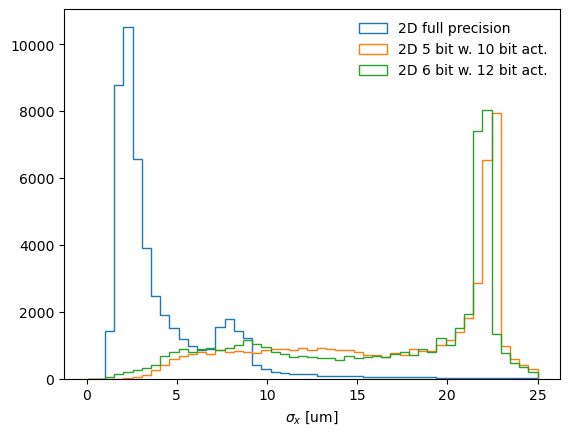

In [23]:
plt.hist(df_2d['sigma'],histtype='step',bins=np.linspace(0,25,50),label=r'2D full precision');
plt.hist(df_2d5['sigma'],histtype='step',bins=np.linspace(0,25,50),label=r'2D 5 bit w. 10 bit act.');
plt.hist(df_2d6['sigma'],histtype='step',bins=np.linspace(0,25,50),label=r'2D 6 bit w. 12 bit act.');
plt.legend(frameon=False)
plt.xlabel(r'$\sigma_x$ [um]')

In [ ]:
plt.hist([df_2d[df_2d['sigma']<7]['xtrue'],df_2d[df_2d['sigma']>7]['xtrue']],bins=np.linspace(-75,75,25),stacked=True,label=['$\sigma_x<7$','$\sigma_x>7$']);
plt.ylim(0,300)
plt.legend(frameon=False)
plt.xlabel('true x [um]')

In [ ]:
plt.hist2d(df_2d['xtrue'],df_2d['sigma'],bins=[np.linspace(-75,75,25),np.linspace(0,25,25)]);
#plt.plot([0,0],[0,25],color='orange')
plt.plot([-75,-75],[0,25],color='orange')
#plt.plot([-50,-50],[0,25],color='orange',linestyle='--')
plt.plot([-25,-25],[0,25],color='orange')
plt.plot([25,25],[0,25],color='orange')
#plt.plot([50,50],[0,25],color='orange',linestyle='--')
plt.plot([75,75],[0,25],color='orange')
plt.xlabel('true x [um]')
plt.ylabel(r'$\sigma_x$ [um]')